In [566]:
import os
from os import environ

import requests
import io
import string

import datetime

import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [567]:
cluster_variables=['Route','Flight Number','Year','Weekday','SEASON']

In [568]:
Raw=pd.concat([pd.read_csv('JAN2017_DEC2017.csv',sep=';'),
pd.read_csv('JAN2018_DEC2018.csv',sep=';'),
pd.read_csv('JAN2019_APR2019.csv',sep=';')])

Raw['Route']=Raw['Sched Airport Depart']+'-'+Raw['Sched Airport Arriva']
Raw=Raw.loc[Raw['Load Factor'].apply(lambda x: x.replace(',','').isnumeric()),:]

In [569]:
Raw['Calendar day']=Raw['Calendar day'].apply(lambda x: pd.to_datetime(x.split('/')[2]+'-'+x.split('/')[1]+'-'+x.split('/')[0]))
Raw['LF_actual']=Raw['Load Factor'].apply(lambda x: float(x.replace(',','.').replace('%',''))/100)
Raw['LF_actual']=Raw['Load Factor'].apply(lambda x: float(x.replace(',','.').replace('%','')))
Raw['Direction']=Raw[['Sched Airport Depart','Sched Airport Arriva']].apply(lambda x: 'O' if x[0]=='LUX' and (x[1]=='CPH' or x[1]=='LCY') else 'I',axis=1)

Raw=Raw.rename(columns={'Calendar day': 'Departure Date'})

In [570]:
Raw=Raw.loc[Raw['Sched Airport Depart'].apply(lambda x: (x=='CPH')|(x=='LCY')|(x=='LUX'))&\
Raw['Sched Airport Arriva'].apply(lambda x: (x=='CPH')|(x=='LCY')|(x=='LUX')),:]

In [571]:
#Raw=Raw.loc[Raw['Departure Date']>=pd.to_datetime('2018-04-01'),:]

In [572]:
Raw['SEASON']='M'

In [573]:
# LUX-CPH

    ## LOW

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-07-31'))&(Raw['Departure Date']<=pd.to_datetime('2017-08-11')),'SEASON']='L'    

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-07-31'))&(Raw['Departure Date']<=pd.to_datetime('2017-08-11')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-08-14'))&(Raw['Departure Date']<=pd.to_datetime('2017-09-17')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-12-19'))&(Raw['Departure Date']<=pd.to_datetime('2017-12-22')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-12-27'))&(Raw['Departure Date']<=pd.to_datetime('2018-01-07')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-07-31'))&(Raw['Departure Date']<=pd.to_datetime('2018-09-17')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-12-27'))&(Raw['Departure Date']<=pd.to_datetime('2019-01-06')),'SEASON']='L'

    ## HIGH

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-04-05'))&(Raw['Departure Date']<=pd.to_datetime('2017-04-08')),'SEASON']='H'    

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-04-28'))&(Raw['Departure Date']<=pd.to_datetime('2017-04-29')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-05-23'))&(Raw['Departure Date']<=pd.to_datetime('2017-05-25')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-06-01'))&(Raw['Departure Date']<=pd.to_datetime('2017-06-05')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-06-22'))&(Raw['Departure Date']<=pd.to_datetime('2017-06-24')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-07-13'))&(Raw['Departure Date']<=pd.to_datetime('2017-07-17')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-08-12'))&(Raw['Departure Date']<=pd.to_datetime('2017-08-13')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-10-27'))&(Raw['Departure Date']<=pd.to_datetime('2017-10-29')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2017-12-15'))&(Raw['Departure Date']<=pd.to_datetime('2017-12-18')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-02-09'))&(Raw['Departure Date']<=pd.to_datetime('2018-02-11')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']==pd.to_datetime('2018-04-01')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-27'))&(Raw['Departure Date']<=pd.to_datetime('2018-04-29')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-08'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-10')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-18'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-21')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-07-13'))&(Raw['Departure Date']<=pd.to_datetime('2018-07-18')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-08-11'))&(Raw['Departure Date']<=pd.to_datetime('2018-08-12')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-10-26'))&(Raw['Departure Date']<=pd.to_datetime('2018-10-28')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2018-12-20'))&(Raw['Departure Date']<=pd.to_datetime('2018-12-23')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2019-02-15'))&(Raw['Departure Date']<=pd.to_datetime('2019-02-17')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2019-04-05'))&(Raw['Departure Date']<=pd.to_datetime('2019-04-07')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='CPH')\
&(Raw['Departure Date']>=pd.to_datetime('2019-04-29'))&(Raw['Departure Date']<=pd.to_datetime('2019-04-30')),'SEASON']='H'

In [574]:
# CPH-LUX

    ## HIGH

Raw.loc[(Raw['Sched Airport Depart']=='CPH')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-01-01'))&(Raw['Departure Date']<=pd.to_datetime('2017-01-02')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='CPH')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-01-06'))&(Raw['Departure Date']<=pd.to_datetime('2017-01-08')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='CPH')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-11-04'))&(Raw['Departure Date']<=pd.to_datetime('2017-11-06')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='CPH')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-12-28'))&(Raw['Departure Date']<=pd.to_datetime('2018-01-03')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='CPH')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-01'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-02')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='CPH')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-08-15'))&(Raw['Departure Date']<=pd.to_datetime('2018-08-16')),'SEASON']='H'

Raw.loc[(Raw['Sched Airport Depart']=='CPH')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2019-01-01'))&(Raw['Departure Date']<=pd.to_datetime('2019-01-07')),'SEASON']='H'

In [575]:
Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY'),'SEASON']='H'
Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX'),'SEASON']='H'

In [576]:
# LUX-LCY

    ## LOW

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-01-01'))&(Raw['Departure Date']<=pd.to_datetime('2017-01-08')),'SEASON']='L'    
 
Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-02-18'))&(Raw['Departure Date']<=pd.to_datetime('2017-02-26')),'SEASON']='L'      
 
Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-04-08'))&(Raw['Departure Date']<=pd.to_datetime('2017-04-23')),'SEASON']='L'      
 
Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-04-28'))&(Raw['Departure Date']<=pd.to_datetime('2017-05-01')),'SEASON']='L'      
 
Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-05-25'))&(Raw['Departure Date']<=pd.to_datetime('2017-05-26')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-06-05'))&(Raw['Departure Date']<=pd.to_datetime('2017-06-11')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']==pd.to_datetime('2017-06-23')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-07-15'))&(Raw['Departure Date']<=pd.to_datetime('2017-09-03')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-10-30'))&(Raw['Departure Date']<=pd.to_datetime('2017-11-01')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-11-04'))&(Raw['Departure Date']<=pd.to_datetime('2017-11-05')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2017-12-18'))&(Raw['Departure Date']<=pd.to_datetime('2018-01-07')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-02-10'))&(Raw['Departure Date']<=pd.to_datetime('2018-02-13')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-02-17'))&(Raw['Departure Date']<=pd.to_datetime('2018-02-18')),'SEASON']='L' 
   
Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-01'))&(Raw['Departure Date']<=pd.to_datetime('2018-04-03')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-07'))&(Raw['Departure Date']<=pd.to_datetime('2018-04-10')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-14'))&(Raw['Departure Date']<=pd.to_datetime('2018-04-15')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-28'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-01')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-10'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-13')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-19'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-21')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-26'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-27')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-07-14'))&(Raw['Departure Date']<=pd.to_datetime('2018-09-09')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-11-01'))&(Raw['Departure Date']<=pd.to_datetime('2018-11-04')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-12-22'))&(Raw['Departure Date']<=pd.to_datetime('2019-01-06')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-06'))&(Raw['Departure Date']<=pd.to_datetime('2019-04-07')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LUX')&(Raw['Sched Airport Arriva']=='LCY')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-13'))&(Raw['Departure Date']<=pd.to_datetime('2019-04-22')),'SEASON']='L'

In [577]:
# LCY-LUX

    ## LOW

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-01-01'))&(Raw['Departure Date']<=pd.to_datetime('2017-01-08')),'SEASON']='L'    

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-02-18'))&(Raw['Departure Date']<=pd.to_datetime('2017-02-26')),'SEASON']='L'    
   
Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-04-08'))&(Raw['Departure Date']<=pd.to_datetime('2017-04-23')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-05-01')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-05-25'))&(Raw['Departure Date']<=pd.to_datetime('2017-05-28')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-06-03'))&(Raw['Departure Date']<=pd.to_datetime('2017-06-11')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-06-23'))&(Raw['Departure Date']<=pd.to_datetime('2017-06-25')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-07-15'))&(Raw['Departure Date']<=pd.to_datetime('2017-09-03')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-10-28'))&(Raw['Departure Date']<=pd.to_datetime('2017-11-01')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-11-04'))&(Raw['Departure Date']<=pd.to_datetime('2017-11-05')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2017-12-18'))&(Raw['Departure Date']<=pd.to_datetime('2018-01-07')),'SEASON']='L' 

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-02-10'))&(Raw['Departure Date']<=pd.to_datetime('2018-02-13')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-02-17'))&(Raw['Departure Date']<=pd.to_datetime('2018-02-18')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-04-01'))&(Raw['Departure Date']<=pd.to_datetime('2018-04-15')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']==pd.to_datetime('2018-05-01')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-10'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-13')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-19'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-21')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-05-26'))&(Raw['Departure Date']<=pd.to_datetime('2018-05-27')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-07-14'))&(Raw['Departure Date']<=pd.to_datetime('2018-09-09')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-11-01'))&(Raw['Departure Date']<=pd.to_datetime('2018-11-04')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2018-12-22'))&(Raw['Departure Date']<=pd.to_datetime('2019-01-06')),'SEASON']='L'

Raw.loc[(Raw['Sched Airport Depart']=='LCY')&(Raw['Sched Airport Arriva']=='LUX')\
&(Raw['Departure Date']>=pd.to_datetime('2019-04-06'))&(Raw['Departure Date']<=pd.to_datetime('2019-04-22')),'SEASON']='L'

In [578]:
Raw=Raw[['Departure Date','Route','Flight Number','Direction','SEASON','LF_actual']]

#Raw['Year']=Raw['Departure Date'].apply(lambda x: x.year)
Raw['Year']='2017'
Raw['Year']=Raw['Departure Date']\
.apply(lambda x: '2017-2018' if (x>=pd.to_datetime('2017-04-01'))&(x<=pd.to_datetime('2018-03-31'))\
else ('2018-2019' if (x>=pd.to_datetime('2018-04-01'))&(x<=pd.to_datetime('2019-03-31')) else 'out'))
Raw=Raw.loc[Raw['Year'].apply(lambda x: (x=='2017-2018')|(x=='2018-2019')),:]

Raw['Month']=Raw['Departure Date'].apply(lambda x: x.month)
Raw['Weekday']=Raw['Departure Date'].apply(lambda x: x.weekday())

In [579]:
Raw=Raw[[x for x in Raw.columns if 'LF' not in x]+[x for x in Raw.columns if 'LF' in x]]

Raw_Mean_Year=Raw.groupby(cluster_variables)['LF_actual'].mean().reset_index()\
.rename(columns={'LF_actual': 'LF_actual_mean'})
Raw_Var_Year=Raw.groupby(cluster_variables)['LF_actual'].var().reset_index()\
.rename(columns={'LF_actual': 'LF_actual_var'})
Raw_N_Year=Raw.groupby(cluster_variables)['LF_actual'].size().reset_index()\
.rename(columns={'LF_actual': 'LF_actual_n'})

replace_value_actual=np.mean(Raw_Var_Year['LF_actual_var'])

Raw_Var_Year['LF_actual_var']=Raw_Var_Year['LF_actual_var'].apply(lambda x: replace_value_actual if pd.isnull(x) or x==0 else x)

In [580]:
Raw_Mean_2017=Raw_Mean_Year.loc[Raw_Mean_Year['Year']=='2017-2018',:].rename(columns={'LF_actual_mean': 'LF_actual_mean_2017'}).copy()
Raw_Mean_2018=Raw_Mean_Year.loc[Raw_Mean_Year['Year']=='2018-2019',:].rename(columns={'LF_actual_mean': 'LF_actual_mean_2018'}).copy()

In [581]:
Raw_Year=Raw_Mean_2017.merge(Raw_Mean_2018,on=[x for x in cluster_variables if x!='Year'])\
.merge(Raw_Mean_2019,on=[x for x in cluster_variables if x!='Year'])
Raw_Year=Raw_Year[[x for x in Raw_Year.columns if 'Year' not in x]]

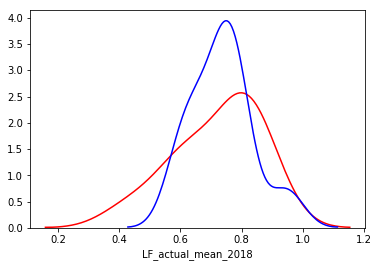

In [588]:
sns.distplot(Raw_Year.loc[(Raw_Year['Route']=='LUX-CPH')&(Raw_Year['SEASON']=='L'),'LF_actual_mean_2017'], 
hist=False, kde=True, color = 'red')

sns.distplot(Raw_Year.loc[(Raw_Year['Route']=='LUX-CPH')&(Raw_Year['SEASON']=='L'),'LF_actual_mean_2018'], 
hist=False, kde=True, color = 'blue')

plt.show()

In [583]:
cluster_variables=[x for x in cluster_variables if x!='Year']

Raw_Mean=Raw.groupby(cluster_variables)['LF_actual'].mean().reset_index()\
.rename(columns={'LF_actual': 'LF_actual_mean'})
Raw_Var=Raw.groupby(cluster_variables)['LF_actual'].var().reset_index()\
.rename(columns={'LF_actual': 'LF_actual_var'})
Raw_N=Raw.groupby(cluster_variables)['LF_actual'].size().reset_index()\
.rename(columns={'LF_actual': 'LF_actual_n'})

replace_value_actual=np.mean(Raw_Var['LF_actual_var'])

Raw_Var['LF_actual_var']=Raw_Var['LF_actual_var'].apply(lambda x: replace_value_actual if pd.isnull(x) or x==0 else x)

In [584]:
Bcg=pd.read_csv('C:/Users/35266/Documents/Python Scripts/el/Spoil upside calculation database with new RPK.csv',sep=';')

Bcg['Route']='LUX'+'-'+Bcg['leg']

Bcg=Bcg.loc[((Bcg['leg']=='CPH')|(Bcg['leg']=='LCY'))&(Bcg['uplift_population']=='YES'),:]
Bcg.index=range(Bcg.shape[0])

Bcg=Bcg[['Departure Date','Route','Flight Number','SEASON','Sum_ASK','Sum_RPK','New RPK']]

Bcg['LF_old']=Bcg['Sum_RPK']/Bcg['Sum_ASK']
Bcg['LF_new']=Bcg['New RPK']/Bcg['Sum_ASK']

Bcg=Bcg[[x for x in Bcg.columns if 'ASK' not in x and 'RPK' not in x]]

Bcg['Departure Date']=Bcg['Departure Date'].apply(lambda x: pd.to_datetime(x.split('.')[2]+'-'+x.split('.')[1]+'-'+x.split('.')[0]))

Bcg['Month']=Bcg['Departure Date'].apply(lambda x: x.month)
Bcg['Weekday']=Bcg['Departure Date'].apply(lambda x: x.weekday())

Bcg=Bcg[[x for x in Bcg.columns if 'LF' not in x]+[x for x in Bcg.columns if 'LF' in x]]

# GROUPINGS

Bcg_Mean=Bcg.groupby(cluster_variables)['LF_old'].mean().reset_index()\
.merge(Bcg.groupby(cluster_variables)['LF_new'].mean().reset_index(),on=cluster_variables)\
.rename(columns={'LF_old': 'LF_old_mean', 'LF_new': 'LF_new_mean'})

Bcg_Var=Bcg.groupby(cluster_variables)['LF_old'].var().reset_index()\
.merge(Bcg.groupby(cluster_variables)['LF_new'].var().reset_index(),on=cluster_variables)\
.rename(columns={'LF_old': 'LF_old_var', 'LF_new': 'LF_new_var'})

Bcg_N=Bcg.groupby(cluster_variables)['LF_old'].size().reset_index()\
.merge(Bcg.groupby(cluster_variables)['LF_new'].size().reset_index(),on=cluster_variables)\
.rename(columns={'LF_old': 'LF_old_n', 'LF_new': 'LF_new_n'})

replace_value_old=np.mean(Bcg_Var['LF_old_var'])
replace_value_new=np.mean(Bcg_Var['LF_new_var'])

Bcg_Var['LF_old_var']=Bcg_Var['LF_old_var'].apply(lambda x: replace_value_old if pd.isnull(x) or x==0 else x)
Bcg_Var['LF_new_var']=Bcg_Var['LF_new_var'].apply(lambda x: replace_value_new if pd.isnull(x) or x==0 else x)

In [585]:
Data=Bcg_Mean.merge(Bcg_Var,on=cluster_variables)\
.merge(Bcg_N,on=cluster_variables)\
.merge(Raw_Mean,on=cluster_variables)\
.merge(Raw_Var,on=cluster_variables)\
.merge(Raw_N,on=cluster_variables)

Data['t_old']=Data[['LF_actual_mean','LF_actual_var','LF_actual_n','LF_old_mean','LF_old_var','LF_old_n']]\
.apply(lambda x: (x[0]-x[3])/np.sqrt((x[1]/x[2])+(x[4]/x[5])),axis=1)

Data['t_new']=Data[['LF_actual_mean','LF_actual_var','LF_actual_n','LF_new_mean','LF_new_var','LF_new_n']]\
.apply(lambda x: (x[0]-x[3])/np.sqrt((x[1]/x[2])+(x[4]/x[5])),axis=1)

Data['Z_larger']=norm.ppf(0.95)
Data['Z_smaller']=-norm.ppf(0.95)

#Data=Data[cluster_variables+['t_old','t_new','Z_larger','Z_smaller']].sort_values(by=['Flight Number','Weekday'])

Data['decision_old']=Data[['t_old','Z_larger','Z_smaller']].apply(lambda x: 'Increase' if x[0]>x[1] else ('Decrease' if x[0]<x[2] else 'Constant'),axis=1)
Data['decision_new']=Data[['t_new','Z_larger','Z_smaller']].apply(lambda x: 'Increase' if x[0]>x[1] else ('Decrease' if x[0]<x[2] else 'Constant'),axis=1)

Data['decision_new']=Data[['LF_old_mean','LF_new_mean','decision_old','decision_new']]\
.apply(lambda x: x[2] if x[0]==x[1] else x[3],axis=1)

Data=Data[cluster_variables+['LF_actual_mean','LF_old_mean','LF_new_mean','decision_old','decision_new']]\
.sort_values(by=cluster_variables)

In [586]:
Data

,Route,Flight Number,Weekday,SEASON,LF_actual_mean,LF_old_mean,LF_new_mean,decision_old,decision_new
0,LUX-CPH,LG-5431,2,M,0.487081,0.500000,0.700000,Constant,Decrease
1,LUX-CPH,LG-5431,3,H,0.479500,0.457143,0.457143,Constant,Constant
2,LUX-CPH,LG-5433,0,M,0.627040,0.404040,0.946276,Increase,Decrease
3,LUX-CPH,LG-5433,1,L,0.535536,0.477706,0.824242,Constant,Decrease
4,LUX-CPH,LG-5433,1,M,0.458358,0.389556,0.725176,Increase,Decrease
5,LUX-CPH,LG-5433,2,H,0.660850,0.471429,0.542857,Constant,Constant
6,LUX-CPH,LG-5433,2,L,0.603271,0.484848,0.702027,Constant,Constant
7,LUX-CPH,LG-5433,2,M,0.449881,0.386889,0.665263,Increase,Decrease
8,LUX-CPH,LG-5433,3,M,0.527965,0.433024,0.772304,Increase,Decrease
9,LUX-CPH,LG-5433,4,L,0.714905,0.363636,0.507576,Increase,Increase
